In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

df = pd.read_csv('/content/drive/MyDrive/CIP/Price_Sorted_Modified.csv')

le_district = LabelEncoder()
df['District'] = le_district.fit_transform(df['District'])
le_crop = LabelEncoder()
df['Crop'] = le_crop.fit_transform(df['Crop'])
df['Price Date'] = pd.to_datetime(df['Price Date'], format='%b-%Y')
df['Month'] = df['Price Date'].dt.month
df['Year'] = df['Price Date'].dt.year

df = df.drop('Price Date', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df[['District', 'Crop', 'Month', 'Year']], df['Crop Price (Rs per quintal)'], test_size=0.2, random_state=42)

imputer = SimpleImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=20)
rf.fit(X_train, y_train)

params = {
    'n_estimators': [100, 150, 250],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_lambda': [0.1, 0.5, 1.0]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

meta_model = LinearRegression()

estimators = [('rf', rf), ('xgb', xgb)]
stack = StackingRegressor(estimators=estimators, final_estimator=meta_model)

stack.fit(X_train, y_train)

y_pred = stack.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error : {:.2f}".format(mse))
print("Root Mean Squared Error : {:.2f}".format(rmse))
print("Mean Absolute Error : {:.2f}".format(mae))
print("R-squared : {:.2f}".format(r2))


Best parameters :  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'reg_lambda': 1.0}
Mean Squared Error : 254.39
Root Mean Squared Error : 15.95
Mean Absolute Error : 14.27
R-squared : 0.974


Text(0, 0.5, 'Number of crops')

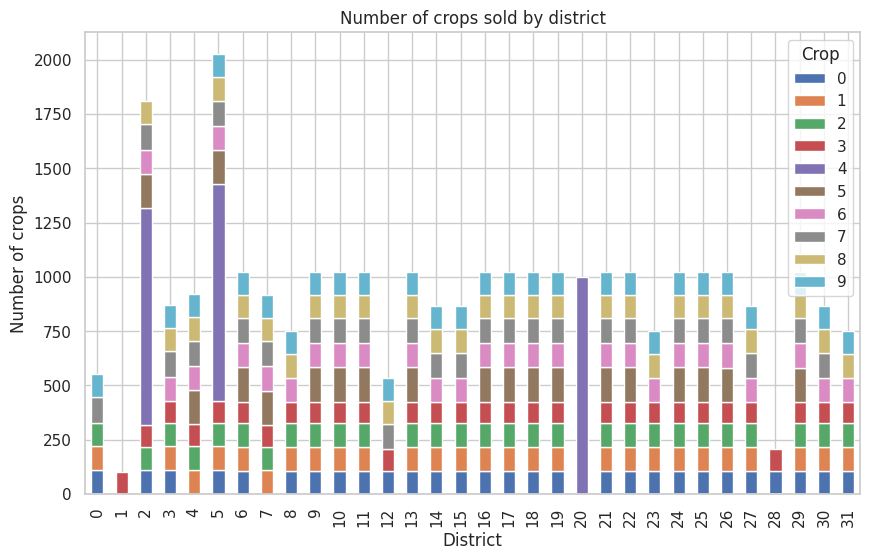

In [4]:
import seaborn as sns

df_counts = df.groupby(['District', 'Crop'])['Crop Price (Rs per quintal)'].count().reset_index()
df_counts.rename(columns={'Crop Price (Rs per quintal)': 'Count'}, inplace=True)

df_pivot = df_counts.pivot(index='District', columns='Crop', values='Count')

sns.set(style='whitegrid')
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Number of crops sold by district')
ax.set_xlabel('District')
ax.set_ylabel('Number of crops')


Predicting Future Crop Price

In [ ]:
district_name = 'Coimbatore'
crop_name = 'Coffee'

today = pd.Timestamp.today()
next_six_months = pd.date_range(today, periods=12, freq='MS').strftime("%m-%Y").tolist()

next_six_months_df = pd.DataFrame({'District': [le_district.transform([district_name])[0]]*12,
                                   'Crop': [le_crop.transform([crop_name])[0]]*12,
                                   'Month': [int(month.split('-')[0]) for month in next_six_months],
                                   'Year': [int(month.split('-')[1]) for month in next_six_months]})

next_six_months_df = imputer.transform(next_six_months_df)
next_six_months_df = scaler.transform(next_six_months_df)
next_six_months_predictions = stack.predict(next_six_months_df)
print ("Look Here --\n\n" , next_six_months_predictions)

next_six_months_table = pd.DataFrame({'Month-Year': next_six_months,
                                      'Predicted Crop Price (Rs per quintal)': next_six_months_predictions.astype(int)})

print(next_six_months_table)


Look Here --

 [18303.50238094 18296.46985612 18297.37274803 18295.77907214
 18294.06787699 18302.72704042 18304.64174455 18268.04105292
 18303.03468692 18291.30151198 18286.94249169 18287.57135467]
   Month-Year  Predicted Crop Price (Rs per quintal)
0     06-2023                                  18303
1     07-2023                                  18296
2     08-2023                                  18297
3     09-2023                                  18295
4     10-2023                                  18294
5     11-2023                                  18302
6     12-2023                                  18304
7     01-2024                                  18268
8     02-2024                                  18303
9     03-2024                                  18291
10    04-2024                                  18286
11    05-2024                                  18287


Saving Trained Model

In [ ]:
! pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import joblib
joblib.dump(stack, 'Crop_EST_Final.joblib')

from google.colab import files
files.download('Crop_EST_Final.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

with open('trained_EST_model.pkl', 'wb') as f:
    pickle.dump(stack, f)

from google.colab import files
files.download('trained_EST_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>